## multi-to-multi step forecast

In [1]:
import os
import math
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

filename = 'shampoo-three-year.csv'

Using TensorFlow backend.


#### preprocessing for time-step forecasting

In [24]:
dataset = pd.read_csv(filename)
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
origin_series = dataset.values

"""
시계열 예측시에는 t, t-1 의 차이값을 value로 활용
"""
def difference(series, interval=1):
    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_ordered(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        train_len = int(x_data.shape[0] * (1 - test_size))
        x_train = x_data[:train_len, :]
        x_test = x_data[train_len:, :]
        y_train =  y_data[:train_len, :]
        y_test = y_data[train_len:, :]
        return (x_train, x_test, y_train, y_test)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

"""
split origin dataset
"""
# def split_dataset():
    

# split origin dataset
origin_x_train, origin_x_test, origin_y_train, origin_y_test = make_timeseries_dataset_ordered(series=origin_series, x_steps=1, y_steps=1, test_size=0.4)
# transform original value to diff value
diff_series = difference(origin_series, 1)
# min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(diff_series)
# split and make timeseries
x_train, x_test, y_train, y_test = make_timeseries_dataset_ordered(series=scaled_series, x_steps=4, y_steps=1, test_size=0.4)

In [25]:
print('training X data shape:', origin_x_train.shape)
print('training Y data shape:', origin_y_train.shape)
print('test X data shape:', origin_x_test.shape)
print('test Y data shape:', origin_y_test.shape)

training X data shape: (21, 1)
training Y data shape: (21, 1)
test X data shape: (14, 1)
test Y data shape: (14, 1)


In [26]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (18, 4)
training Y data shape: (18, 1)
test X data shape: (13, 4)
test Y data shape: (13, 1)


In [27]:
# data reshape : for trim batch size (train, predict in Neural Networks)
x_train = x_train[:16, :]
y_train = y_train[:16, :]
x_test = x_test[:12, :]
y_test = y_test[:12, :]

In [28]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (16, 4)
training Y data shape: (16, 1)
test X data shape: (12, 4)
test Y data shape: (12, 1)


#### change shape for (LSTM or RNN)

In [29]:
"""
(size, timestep, feature) 의 형식으로 맞춰줘야 함
size : batch를 돌 데이터 사이즈
timestep : input의 time 개수 (X_t1, X_t2...)
feature : feature의 개수 (X = x1, x2 ...) [ex: x1 - 키, x2 - 몸무게 ...]
"""

time_step = 4
feature_num = 1

x_train_series = x_train.reshape(x_train.shape[0], time_step, feature_num)
x_test_series = x_test.reshape(x_test.shape[0], time_step, feature_num)

#### LSTM modeling code

In [30]:
num_epochs = 500
batch_size=4

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train_series, y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
16/16 [==============================] - 0s 27ms/step - loss: 0.2354
epochs : 1
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.2227
epochs : 2
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.2106
epochs : 3
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.1991
epochs : 4
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.1882
epochs : 5
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.1777
epochs : 6
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.1676
epochs : 7
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.1578
epochs : 8
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.1483
epochs : 9
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.1391
epochs : 10
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.1302
epochs : 11
Epoch 1

16/16 [==============================] - 0s 1ms/step - loss: 0.0330
epochs : 92
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0330
epochs : 93
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0329
epochs : 94
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0328
epochs : 95
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.0328
epochs : 96
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0327
epochs : 97
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0327
epochs : 98
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0326
epochs : 99
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0326
epochs : 100
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0325
epochs : 101
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0325
epochs : 102
Epoch 1/1
16/16 [

16/16 [==============================] - 0s 1ms/step - loss: 0.0294
epochs : 182
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0293
epochs : 183
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0293
epochs : 184
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0293
epochs : 185
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0292
epochs : 186
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0292
epochs : 187
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0292
epochs : 188
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0291
epochs : 189
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0291
epochs : 190
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0291
epochs : 191
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0291
epochs : 192
Epoch 1/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0268
epochs : 272
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0268
epochs : 273
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0267
epochs : 274
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.0267
epochs : 275
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0267
epochs : 276
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0266
epochs : 277
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0266
epochs : 278
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0266
epochs : 279
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0266
epochs : 280
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0265
epochs : 281
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0265
epochs : 282
Epoch 1/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0242
epochs : 362
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0241
epochs : 363
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0241
epochs : 364
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0241
epochs : 365
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0241
epochs : 366
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0240
epochs : 367
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0240
epochs : 368
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0240
epochs : 369
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0239
epochs : 370
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0239
epochs : 371
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0239
epochs : 372
Epoch 1/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0219
epochs : 452
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0219
epochs : 453
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0219
epochs : 454
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0218
epochs : 455
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0218
epochs : 456
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0218
epochs : 457
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.0218
epochs : 458
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0218
epochs : 459
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0217
epochs : 460
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0217
epochs : 461
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0217
epochs : 462
Epoch 1/1

In [31]:
def show_train_fit():
    output = model.predict(x_train_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_train[i+1]
        predictions.append(yhat)
    model.reset_states()
    return predictions

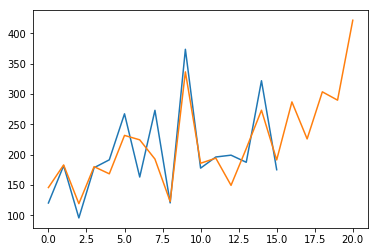

In [32]:
predictions = show_train_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_train) # yellow line
plt.show()

In [33]:
def show_test_fit():
    output = model.predict(x_test_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_test[i+1]
        predictions.append(yhat)
    model.reset_states()
    return predictions

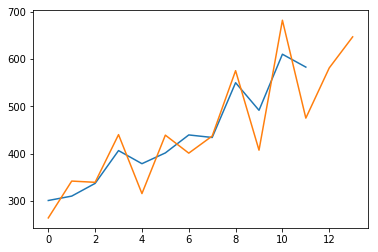

In [34]:
predictions = show_test_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_test) # yellow line
plt.show()

## bitcoin data with LSTM

https://www.blockchain.com/ko/charts/market-price?timespan=60days